In [48]:
%load_ext autoreload
%autoreload 2

In [21]:
from notebook_utils.utils import *
from notebook_utils.data_generation import *
from pycss.subset_selection import *
from pycss.utils import *
from pycss.PCSS import *
from pycss.model_selection import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import chi2
from scipy.stats import skewcauchy
from choldate import cholupdate
import multiprocessing
from multiprocessing import Pool
from functools import partial
from tqdm.notebook import tqdm

In [47]:
def cov_df(p):
    return int(p*(p+1)/2)

def model_df(p, k, noise):
    if noise == 'sph':
        return cov_df(k) + (p-k)*k + 1 if k < p else cov_df(p)
    if noise == 'diag':
        return cov_df(k) + (p-k)*(k+ 1)

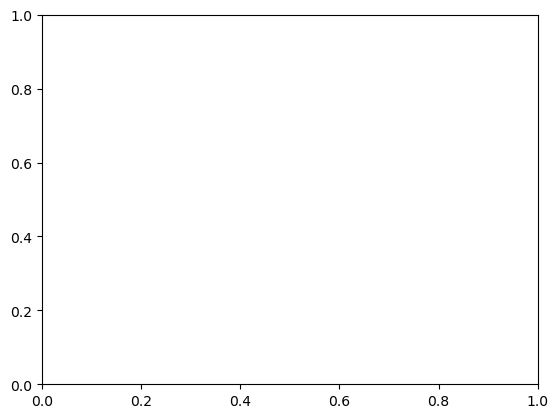

In [6]:
p = 50
k = 20
n = 500
real_dist = sample_LRT_stat_under_null(n, p, k, B=int(1e6), noise='sph')
plt.hist(real_dist, bins=100, density=True, alpha=0.5, label='Pivotal Dist.')
x = np.arange(min(real_dist), max(real_dist), 0.001)
plt.plot(x, chi2.pdf(x, df=cov_df(p) - model_df(p, k, 'sph')), alpha=0.7, label='Wilks Dist.')
plt.legend()
plt.savefig("../figures/pivotal500.pdf")
plt.cla()

p = 50
k = 20
n = 5000
real_dist = sample_LRT_stat_under_null(n, p, k, B=int(1e6), noise='sph')
plt.hist(real_dist, bins=100, density=True, alpha=0.5, label='Pivotal Dist.')
x = np.arange(min(real_dist), max(real_dist), 0.001)
plt.plot(x, chi2.pdf(x, df=cov_df(p) - model_df(p, k, 'sph')), alpha=0.7, label='Wilks Dist.')
plt.legend()
plt.savefig("../figures/pivotal5000.pdf")
plt.cla()

In [2]:
def summarize_results(results):
    
    excesses = []
    for i in range(len(ns)):
        excesses.append(results[i, np.where(results[i, :] > k)[0]] - k)
    mean_excess = np.array([np.mean(excess) for excess in excesses])
    std_excess = np.array([np.std(excess, ddof=1) for excess in excesses])
    num_excess = np.array([len(excess) if len(excess) > 0 else np.nan for excess in excesses])

    
    dearths = []
    for i in range(len(ns)):
        dearths.append(k - results[i, np.where(results[i, :] < k)[0]])
        
    mean_dearth = np.array([np.mean(dearth) for dearth in dearths])
    std_dearth = np.array([np.std(dearth, ddof=1) for dearth in dearths])
    num_dearth = np.array([len(dearth) if len(dearth) > 0 else np.nan for dearth in dearths])

    print("Mean Type I Error")
    print(np.mean(results > k, axis=1))
    print("Std Type I Error")
    print(1/np.sqrt(B) * np.std(results > k, axis=1))
    print("Mean Excess Type I Error")
    print(mean_excess)
    print("Std. Excess Type I Error")
    print(1/np.sqrt(num_excess) * np.array(std_excess))
    print("Mean Loss in Power")
    print(mean_dearth)
    print("Std. Loss in Power")
    print(1/np.sqrt(num_dearth) * np.array(std_dearth))
    print("Mean Power")
    print(np.mean(results == k, axis=1))
    print("Std. Power")
    print(1/np.sqrt(B) * np.std(results == k, axis=1))

In [29]:
p = 50
k = 20
C_chol = get_equicorrelated_chol(k, 0.25, diag=1)
C = C_chol @ C_chol.T
sigma_sq = 0.2

W = get_block_W(p, k, num_blocks=4, block_size=8, overlap=4)

np.random.seed(0)
W *= np.random.choice(np.array([-1, 1]), W.shape)
W*np.sqrt(1/8)

D = np.concatenate([np.arange(0.1, 0.8, step=0.1), np.arange(0.1, 0.8, step=0.1), np.arange(0.1, 0.8, step=0.1), np.arange(0.1, 1.0, step=0.1)])
#signal_sizes = np.sum(W * (W @ C), axis=1)
#W = np.sqrt(1 - sigma_sq)/np.sqrt(signal_sizes)[:, None] * W

B = 1000
noise = 'diag'
method = 'swap'
num_inits = 25
ns = [500]
alpha = 0.1

In [30]:
quantiles = {}

for n in ns:
    for i in range(1, p-1):
        quantiles[(n, p, i, 1 - alpha, noise)] = Q(1 - alpha, n, p, i, noise=noise)

$X_S$ is Gaussian

In [18]:
results = np.zeros((len(ns), B))
for i, n in tqdm(enumerate(ns)):
    #Sigma_hats = generate_gaussian_PCSS_sample_cov(n, C_chol, W, sigma_sq=sigma_sq, B=B)
    Sigma_hats = generate_gaussian_PCSS_sample_cov(n, C_chol, W, D=D, B=B)
    mp_LRT = partial(sieves_gaussian_LRT, n=n, alpha=alpha, noise=noise, method=method, num_inits=num_inits, quantiles=quantiles)
    with Pool(multiprocessing.cpu_count()) as pool:
        results[i, :] = [len(S) for S in list(tqdm(pool.imap_unordered(mp_LRT, list(Sigma_hats))))]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [19]:
summarize_results(results)

Mean Type I Error
[0.    0.003 0.024]
Std Type I Error
[0.         0.00172945 0.00483983]
Mean Excess Type I Error
[ nan 1.   1.25]
Std. Excess Type I Error
[       nan 0.         0.10851434]
Mean Loss in Power
[ 1. nan nan]
Std. Loss in Power
[nan nan nan]
Mean Power
[0.999 0.997 0.976]
Std. Power
[0.0009995  0.00172945 0.00483983]


$X_S$ is Uniform

In [28]:
results = np.zeros((len(ns), B))
for i, n in tqdm(enumerate(ns)):
    X_S = np.random.uniform(low=-np.sqrt(3), high=np.sqrt(3), size=(B, n, k))
    X = generate_gaussian_PCSS_data(n, W=W, X_S=X_S, D=D, B=B)
    X_c = X - np.mean(X, axis=1)[:, np.newaxis, :]  
    Sigma_hats = 1/n * np.transpose(X_c, (0, 2, 1) ) @ X_c
    mp_LRT = partial(sieves_gaussian_LRT, n=n, alpha=alpha, noise=noise, method=method, num_inits=num_inits, quantiles=quantiles)
    with Pool(multiprocessing.cpu_count()) as pool:
        results[i, :] = [len(S) for S in list(tqdm(pool.imap_unordered(mp_LRT, list(Sigma_hats))))]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [29]:
summarize_results(results)

Mean Type I Error
[0.137 0.121 0.112]
Std Type I Error
[0.01087341 0.01031305 0.00997276]
Mean Excess Type I Error
[1.4379562  1.23966942 1.35714286]
Std. Excess Type I Error
[0.07673939 0.0454921  0.06063948]
Mean Loss in Power
[nan nan nan]
Std. Loss in Power
[nan nan nan]
Mean Power
[0.863 0.879 0.888]
Std. Power
[0.01087341 0.01031305 0.00997276]


$X_S$ is Rademacher

In [30]:
results = np.zeros((len(ns), B))
for i, n in tqdm(enumerate(ns)):
    X_S = np.random.choice(np.array([-1, 1]), size=(B, n, k))
    X = generate_gaussian_PCSS_data(n, W=W, X_S=X_S, D=D, B=B)
    X_c = X - np.mean(X, axis=1)[:, np.newaxis, :]  
    Sigma_hats = 1/n * np.transpose(X_c, (0, 2, 1) ) @ X_c
    mp_LRT = partial(sieves_gaussian_LRT, n=n, alpha=alpha, noise=noise, method=method, num_inits=num_inits, quantiles=quantiles)
    with Pool(multiprocessing.cpu_count()) as pool:
        results[i, :] = [len(S) for S in list(tqdm(pool.imap_unordered(mp_LRT, list(Sigma_hats))))]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [31]:
summarize_results(results)

Mean Type I Error
[0.125 0.117 0.115]
Std Type I Error
[0.01045825 0.0101642  0.01008836]
Mean Excess Type I Error
[1.312      1.35042735 1.32173913]
Std. Excess Type I Error
[0.06663913 0.06459678 0.0531937 ]
Mean Loss in Power
[nan nan nan]
Std. Loss in Power
[nan nan nan]
Mean Power
[0.875 0.883 0.885]
Std. Power
[0.01045825 0.0101642  0.01008836]


$X_S$ is categorical

In [16]:
results = np.zeros((len(ns), B))
for i, n in tqdm(enumerate(ns)):
    X_S = np.random.choice(np.array([0, 1, 2, 3, 4]), size=(B, n, k))
    X = generate_gaussian_PCSS_data(n, W=W, X_S=X_S, D=D, B=B)
    X_c = X - np.mean(X, axis=1)[:, np.newaxis, :]  
    Sigma_hats = 1/n * np.transpose(X_c, (0, 2, 1) ) @ X_c
    mp_LRT = partial(sieves_gaussian_LRT, n=n, alpha=alpha, noise=noise, method=method, num_inits=num_inits, quantiles=quantiles)
    with Pool(multiprocessing.cpu_count()) as pool:
        results[i, :] = [len(S) for S in list(tqdm(pool.imap_unordered(mp_LRT, list(Sigma_hats))))]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [17]:
summarize_results(results)

Mean Type I Error
[0.101 0.095 0.109]
Std Type I Error
[0.00952885 0.00927227 0.0098549 ]
Mean Excess Type I Error
[1.46534653 1.22105263 1.31192661]
Std. Excess Type I Error
[0.09393948 0.04774641 0.06071447]
Mean Loss in Power
[nan nan nan]
Std. Loss in Power
[nan nan nan]
Mean Power
[0.899 0.905 0.891]
Std. Power
[0.00952885 0.00927227 0.0098549 ]


$X_S$ is skew Cauchy with $a=0.5$

In [33]:
results = np.zeros((len(ns), B))
for i, n in tqdm(enumerate(ns)):
    #X_S = np.square(np.random.standard_t(df=5, size=(B, n, k)))
    X_S = skewcauchy.rvs(a=0.5, size=(B, n, k))
    X = generate_gaussian_PCSS_data(n, W=W, X_S=X_S, D=D, B=B)
    X_c = X - np.mean(X, axis=1)[:, np.newaxis, :]  
    Sigma_hats = 1/n * np.transpose(X_c, (0, 2, 1) ) @ X_c
    mp_LRT = partial(sieves_gaussian_LRT, n=n, alpha=alpha, noise=noise, method=method, num_inits=num_inits, quantiles=quantiles)
    with Pool(multiprocessing.cpu_count()) as pool:
        results[i, :] = [len(S) for S in list(tqdm(pool.imap_unordered(mp_LRT, list(Sigma_hats))))]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [34]:
summarize_results(results)

Mean Type I Error
[0.098]
Std Type I Error
[0.00940191]
Mean Excess Type I Error
[1.26530612]
Std. Excess Type I Error
[0.05719994]
Mean Loss in Power
[nan]
Std. Loss in Power
[nan]
Mean Power
[0.902]
Std. Power
[0.00940191]


### Real Data Analysis

In [2]:
def log_likelihood_plot(X, k_max, method='greedy', noise='sph', num_inits=1, plot=True):
    
    log_likelihoods = np.zeros(k_max)
    
    pcss = PCSS()
    if method == 'greedy':
        
        pcss.compute_MLE_from_data(X, k_max, noise=noise, method='greedy')
        S_greedy = pcss.S.copy()
        
        for i in range(1, k_max+1):
            pcss.compute_MLE_from_data(X, i, noise=noise, method='swap', S_init=S_greedy[:i], max_iter=0)
            log_likelihoods[i - 1] = pcss.log_likelihood
    
    if method == 'swap':
        
        for i in range(1, k_max + 1):
            best_log_likelihood = -np.inf
            for j in range(num_inits):
                pcss.compute_MLE_from_data(X, k_max, noise=noise, method='swap')
                if pcss.log_likelihood > best_log_likelihood:
                    best_log_likelihood = pcss.log_likelihood
            log_likelihoods[i - 1] = best_log_likelihood
    
    if plot:
        plt.plot(np.arange(1, k_max + 1), log_likelihoods)
    
    return log_likelihoods 

In [ ]:
def css_obj_plot(X, k_max, method='greedy', noise='sph', num_inits=1):
    
    objs = np.array(k_max)
    _, Sigma_hat = get_moments(X)
    
    css = CSS()
    if method == 'greedy':
        
        css.select_subset_from_data(X, k_max, noise=noise, method='greedy')
        S_greedy = css.S.copy()
        
        for i in range(1, k_max+1):
            objs[i - 1] = np.trace(regress_off(Sigma_hat, S_greedy[:i]))
    
    if method == 'swap':
        for i in range(1, k_max + 1)
            best_obj = np.inf
            for j in range(num_inits):
                css.select_subset_from_data(X, k_max, noise=noise, method='swap')
                potential_obj = np.trace(css.Sigma_R)
                if potential_obj < best_obj:
                    best_obj = potential_obj
            objs[i - 1] = best_obj
        

Factor Analysis Example

In [3]:
X = pd.read_csv("../data/BFI228.csv").values[:, 1:]
n = len(X)
_, Sigma_hat = get_moments(X)

In [4]:
alpha=0.05
S = sieves_gaussian_LRT(Sigma_hat, n, alpha, noise='diag', num_inits=100)
print(len(S))
print(np.sort(S))
print(len(np.where(np.logical_and(S>=0, S<=7))[0]))
print(len(np.where(np.logical_and(S>=8, S<=16))[0]))
print(len(np.where(np.logical_and(S>=17, S<=25))[0]))
print(len(np.where(np.logical_and(S>=26, S<=33))[0]))
print(len(np.where(np.logical_and(S>=34, S<=43))[0]))

19
[ 0  2  6  7 12 13 14 15 19 20 22 24 25 27 29 31 37 38 43]
4
4
5
3
3


In [5]:
np.diag(Sigma_hat)

array([0.9348261 , 1.01313866, 0.80030394, 0.91012619, 1.32846645,
       0.84672207, 1.33264081, 0.87309557, 1.08192906, 0.52468067,
       0.9600454 , 0.81525085, 0.85385888, 1.15010388, 0.53945445,
       1.19313635, 0.51123423, 0.71843259, 1.19504078, 0.52300708,
       1.56086488, 1.4644506 , 1.02854725, 0.71396968, 0.80255463,
       1.2689289 , 1.21021853, 1.21506617, 1.19119344, 1.56561634,
       1.35056941, 1.22366497, 1.08102493, 1.35080025, 0.83302555,
       0.53462604, 1.0999346 , 0.94003924, 1.06017236, 1.20966066,
       1.20675592, 0.8138658 , 1.35772545, 1.76100339])

In [8]:
pcss = PCSS()
pcss.compute_MLE_from_data(X, k=19, method='swap', noise='diag')

In [13]:
np.median(pcss.MLE['D_MLE']/np.diag(Sigma_hat)[complement(Sigma_hat.shape[0], pcss.MLE['S_MLE'])])

0.5517239936121213

array([-60.3423477 , -58.87962234, -57.8619868 , -56.84200897,
       -55.95497102, -55.19392631, -54.68495592, -54.28894891,
       -53.92932439, -53.62967876, -53.36278682, -53.09784594,
       -52.85467767, -52.65842716, -52.45794613, -52.32042739,
       -52.18321357, -52.06816287, -51.95534743, -51.8577381 ,
       -51.76251393, -51.67501639, -51.59066329, -51.51125909,
       -51.44409272, -51.38409591, -51.32872565, -51.27927776,
       -51.23998294, -51.20289194, -51.16785727, -51.13596826,
       -51.10637903, -51.08976877, -51.07310959, -51.06067457,
       -51.05051576, -51.04594457, -51.04261743, -51.04078696,
       -51.03929904, -51.03860462, -51.03841693, -51.03841693])

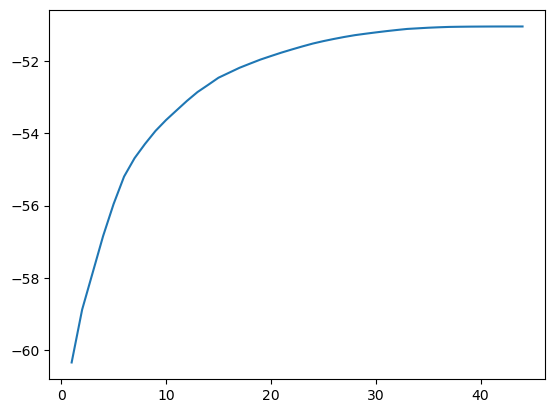

In [16]:
log_likelihood_plot(X, X.shape[1], noise='diag')

In [22]:
X = pd.read_csv("../data/CPAI537.csv").values[:, 1:]
n = len(X)
_, Sigma_hat = get_moments(X)

In [25]:
alpha=0.05
len(sieves_gaussian_LRT(Sigma_hat, n, alpha, noise='diag', num_inits=10))

1 3729.250388837847 405.0066397047172
2 2761.3621657848344 377.1923991538491
3 2117.224925009549 350.18164244205286
4 1646.5784119503353 324.1061908573692
5 1348.3610431523578 299.5768016788182
6 1085.074817091662 275.06350716167873
7 839.4207026762065 252.28158790189508
8 687.4780332077136 230.4543697889319
9 561.4107340911382 209.0890191427209
10 440.43147360632435 188.95433832421745
11 342.38526636483317 170.06167477312115
12 262.7106002315591 151.96726774017299
13 201.8434286440692 134.88869727521703
14 152.5370375399716 118.59490281430998
15 117.48063180037192 103.48929827732618
16 90.5202301829355 89.54608117532098
17 64.49840381574525 76.41258383387363


17

array([-58.74923199, -57.84803253, -57.24827718, -56.81005883,
       -56.5449832 , -56.29770716, -56.05851533, -55.91704171,
       -55.80773526, -55.71035142, -55.61951723, -55.53485754,
       -55.46856382, -55.42677628, -55.3926911 , -55.36121508,
       -55.33698619, -55.32089135, -55.30758932, -55.29528469,
       -55.2872099 , -55.28175328, -55.27908985, -55.2774319 ,
       -55.27701101, -55.27693535, -55.27693181, -55.27693181])

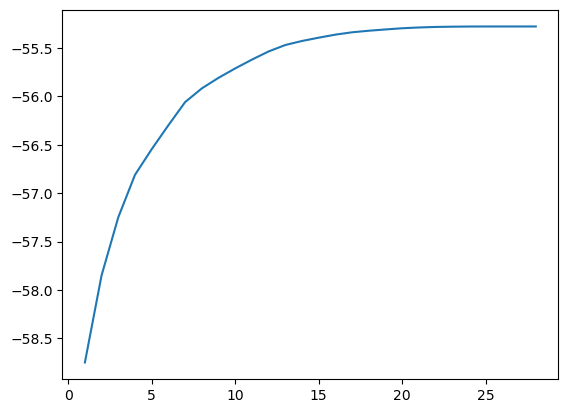

In [8]:
log_likelihood_plot(X, X.shape[1], noise='diag')

Dermatology

In [118]:
derm_df = pd.read_csv('../data/dermatology.data', header=None)
X = derm_df.values
to_keep = []
for i in range(len(X)):
    if '?' in X[i, :]:
        continue 
    to_keep.append(i)
X = X[to_keep, :]
X = X.astype(float)
n, p = X.shape
_, Sigma_hat = get_moments(X)
len(sieves_gaussian_LRT(Sigma_hat, n, alpha, noise='diag', num_inits=10))

16

In [35]:
pcss = PCSS()
pcss.compute_MLE_from_data(X, k=30, method='swap', noise='diag')

In [25]:
np.median(pcss.MLE['D_MLE']/np.diag(Sigma_hat)[complement(Sigma_hat.shape[0], pcss.MLE['S_MLE'])])

0.5423160601868258

In [36]:
print(np.diag(Sigma_hat)[complement(Sigma_hat.shape[0], pcss.MLE['S_MLE'])])
print(pcss.MLE['D_MLE'])

[0.84672207 1.08192906 0.52468067 0.9600454  0.81525085 0.51123423
 1.19504078 0.52300708 1.02854725 1.21021853 1.08102493 1.35080025
 0.53462604 1.35772545]
[0.44627551 0.71577015 0.34731415 0.45510223 0.51797407 0.2431376
 0.67759675 0.2636246  0.53832145 0.55381256 0.49689113 0.60477546
 0.30926602 0.90807241]


QSAR

In [98]:
qsar_df = pd.read_csv('../data/biodeg.csv', delimiter=';', header=None)
X = qsar_df.values
X = X[:, :X.shape[1] - 1]
n, p = X.shape
_, Sigma_hat = get_moments(X)
Sigma_hat = Sigma_hat.astype(float)
#Sigma_hat = standardize_cov(Sigma_hat).astype(float)
print(p)

41


In [99]:
alpha=0.05
len(sieves_gaussian_LRT(Sigma_hat, n, alpha, noise='diag', num_inits=10))

32

Stocks Example

In [68]:
stocks_df = pd.read_csv('../data/stocks_normalized.csv')
stocks = list(stocks_df.columns)[1:]
X = stocks_df.to_numpy()[:, 1:].astype(float)
mu_hat, Sigma_hat = get_moments(X)
n, p = X.shape
X_standardized = (X - mu_hat) * 1/np.sqrt(np.diag(Sigma_hat))[None, :] + mu_hat
mu_hat, Sigma_hat = get_moments(X_standardized)

In [69]:
alpha = 0.05
S = sieves_gaussian_LRT(Sigma_hat, n, alpha, noise='diag', num_inits=100)
print(np.sort(S))

[ 1  4  5  7  8 10 11 13 16 17 19]
